# 0. Setup

In [ ]:
# reload all modules every time before executing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from pathlib import Path
import sys, types

import numpy as np

In [ ]:
# Patch for pickle compatibility
if 'recover_core_lib' not in sys.modules:
    print('adding `recover_core_lib` to sys')
    fake = types.ModuleType('recover_core_lib')
    fake.compute_CAM2_translations_v3_cupy = lambda *a, **k: None
    sys.modules['recover_core_lib'] = fake

adding `recover_core_lib` to sys


In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
# this automatically displays all plots, even if we don't have plt.show()
# this also makes all plots interactive
%matplotlib widget

# 1. Load Data

In [ ]:
from collections import defaultdict

In [ ]:
BASE_DIR = Path('../data/experiment_01/')
exp_dirs = sorted([d for d in BASE_DIR.iterdir() if d.is_dir()])
print(f'Found {len(exp_dirs)} experiment directories')
exp_dirs

Found 8 experiment directories


[PosixPath('../data/experiment_01/cube_pos1_29_12_Time_19_16_40'),
 PosixPath('../data/experiment_01/cube_pos2_29_12_Time_19_03_39'),
 PosixPath('../data/experiment_01/cube_pos2_29_12_Time_19_13_50'),
 PosixPath('../data/experiment_01/cube_pos3_29_12_Time_19_27_21'),
 PosixPath('../data/experiment_01/cube_pos3_29_12_Time_19_29_43'),
 PosixPath('../data/experiment_01/cube_pos4_29_12_Time_19_24_21'),
 PosixPath('../data/experiment_01/cube_pos5_29_12_Time_19_22_12'),
 PosixPath('../data/experiment_01/cube_pos6_29_12_Time_19_20_07')]

In [ ]:
def load_data(exp_dirs) -> dict:
    """Load recovery and metadata from an experiment directory."""

    duplicate_idx_map = defaultdict(int)
    data = {}

    for exp_dir in exp_dirs:
        recovery = np.load(exp_dir / 'RECOVERY.npz', allow_pickle=True)
        fs = recovery['run_opt'].item()['cam_params']['camera_FPS'] # use frames-per-second as sampling-frequency

        object = str(exp_dir).split('/')[-1].split('_')[0]
        position = int(str(exp_dir).split('/')[-1].split('_')[1][3:])

        key = (object, position)
        duplicate_idx_map[key] += 1
        duplicate_idx = duplicate_idx_map[key]

        name = f'{object}-pos{position}-{duplicate_idx:02}'
        shifts_raw = recovery['all_shifts']

        time = np.arange(shifts_raw.shape[1]) / fs

        d = {
            'object': object,
            'position': position,
            'duplicate_idx': duplicate_idx,
            'fs': fs,
            'path': exp_dir,
            'shifts_raw': shifts_raw,
            'time': time,
        }
        data[name] = d
    return data

In [ ]:
data = load_data(exp_dirs)
len(data)

8

In [ ]:
list(data.keys())

['cube-pos1-01',
 'cube-pos2-01',
 'cube-pos2-02',
 'cube-pos3-01',
 'cube-pos3-02',
 'cube-pos4-01',
 'cube-pos5-01',
 'cube-pos6-01']

In [ ]:
list(list(data.values())[0].keys())

['object', 'position', 'duplicate_idx', 'fs', 'path', 'shifts_raw', 'time']

# 2. Compute FFT

In [ ]:
def shifts_to_fft(shifts, fs, min_freq=None, max_freq=None):
    # compute fft values and frequencies
    fft_val = np.fft.rfft(shifts, axis=1)
    n_samples = shifts.shape[1]
    freq = np.fft.rfftfreq(n_samples, d=1.0/fs)

    # crop the frequency
    if min_freq is not None and max_freq is not None:
        mask = (freq >= min_freq) & (freq <= max_freq)
        fft_val, freq = fft_val[:, mask, :], freq[mask]
    return fft_val, freq

In [ ]:
def fft_magnitude(fft_vals, return_std=False):
    """Compute fft magnitude and average it over all the lasers and x,y coordinates"""
    if len(fft_vals.shape) == 3: # (n_lasers, n_freqs, n_coords)
        fft_mag_mean = np.abs(fft_vals).mean(axis=(0,2))
        return (fft_mag_mean, np.abs(fft_vals).std(axis=(0,2))) if return_std else fft_mag_mean
    elif len(fft_vals.shape) == 2: # (n_lasers, n_coords) we already chose a specific frequency
        fft_mag_mean = np.abs(fft_vals).mean()
        return (fft_mag_mean, np.abs(fft_vals).std()) if return_std else fft_mag_mean
    else:
        raise ValueError()

In [ ]:
def fft_angle(fft_vals, return_std=False):
    """Compute fft angle and average it over all the lasers and x,y coordinates"""
    if len(fft_vals.shape) == 3: # (n_lasers, n_freqs, n_coords)
        fft_mag_mean = np.angle(fft_vals).mean(axis=(0,2))
        return (fft_mag_mean, np.angle(fft_vals).std(axis=(0,2))) if return_std else fft_mag_mean
    elif len(fft_vals.shape) == 2: # (n_lasers, n_coords) we already chose a specific frequency
        fft_mag_mean = np.angle(fft_vals).mean()
        return (fft_mag_mean, np.angle(fft_vals).std()) if return_std else fft_mag_mean
    else:
        raise ValueError()

# 3. Clean Data

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt

In [ ]:
def bandpass_filter(shifts, fs, lowcut=50, highcut=None, order=5):
    """Removes frequencies outside of [lowcut, highcut].
    sosfiltfilt applies the filter forward and backward, giving zero phase distortion."""
    if highcut is None: highcut = fs / 2 - 10  # Slightly below Nyquist frequency

    n_lasers, _, n_coords = shifts.shape
    filtered_shifts = np.empty_like(shifts)

    for i in range(n_lasers):
        for j in range(n_coords):
            sos = butter(order, [lowcut, highcut], fs=fs, btype='band', output='sos')
            filtered_shifts[i, :, j] = sosfiltfilt(sos, shifts[i, :, j])
    return filtered_shifts

In [ ]:
def hann_window(shifts):
    window = np.hanning(shifts.shape[1])
    return shifts * window[:, np.newaxis]

In [ ]:
def plot_clean_data(shifts, fs, xlim=(None, None)):
    # fft for raw signal
    fft_vals, freq = shifts_to_fft(shifts, fs)

    # fft for bandpass filter
    bp_shifts = bandpass_filter(shifts, fs)
    bp_fft_vals, bp_freq = shifts_to_fft(bp_shifts, fs)

    # fft for bandpass filter + hann window
    wd_shifts = hann_window(bp_shifts)
    wd_fft_vals, wd_freq = shifts_to_fft(wd_shifts, fs)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(freq, fft_magnitude(fft_vals), label='raw')
    ax.plot(bp_freq, fft_magnitude(bp_fft_vals), label='bandpass filter')
    ax.plot(wd_freq, fft_magnitude(wd_fft_vals), label='bandpass filter + hann window')
    ax.set(xlim=xlim, ylim=(0, 200), xlabel='Frequency (Hz)', ylabel='Mean FFT Magnitude')
    ax.legend()
    fig.suptitle('Clean the Data')
    return fig

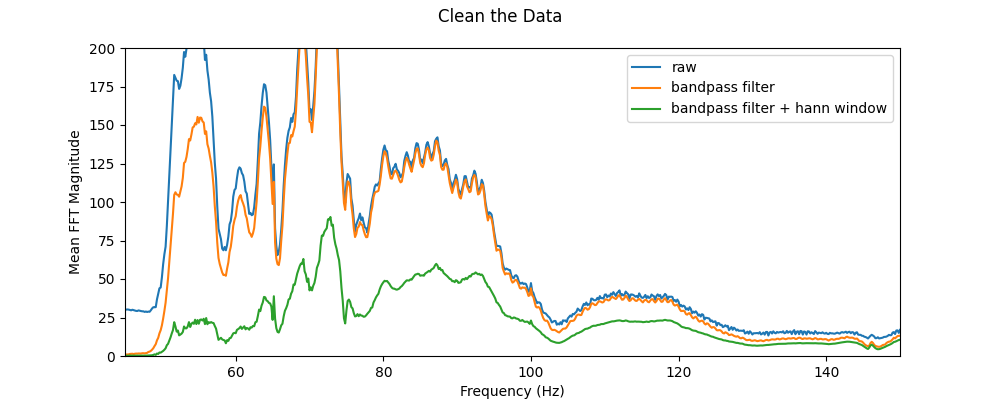

In [ ]:
d = list(data.values())[0]
fig = plot_clean_data(d['shifts_raw'], d['fs'], xlim=(45, 150))

The fft vals looks much cleaner with bandpass filter + hann window. Let's define a function to clean the shifts and compute the fft on this cleaned data.

In [ ]:
def clean_shifts(shifts, fs):
    shifts_bp = bandpass_filter(shifts, fs)
    shifts_wd = hann_window(shifts_bp)
    return shifts_wd

Now let's take a look at all the frequencies.

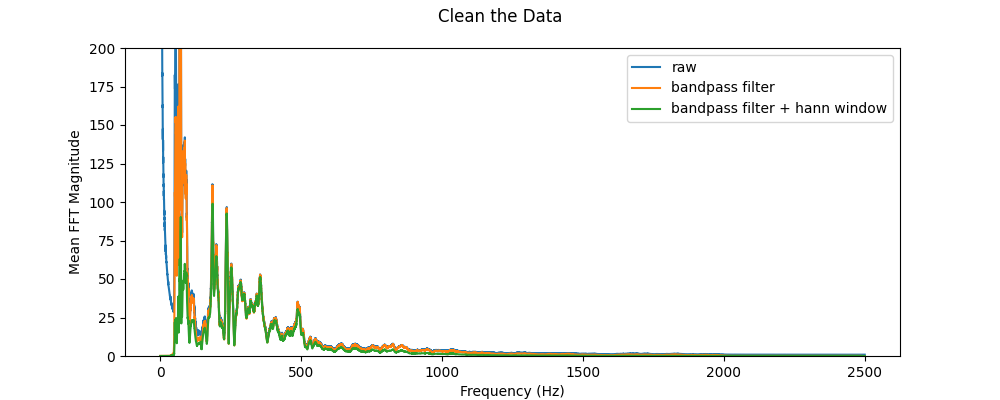

In [ ]:
fig = plot_clean_data(d['shifts_raw'], d['fs'])

Notice that there isn't really any signal after 1000 hz so we'll crop it at 1100 hz.

In [ ]:
MIN_FREQ, MAX_FREQ = 50, 1_000

In [ ]:
for name, d in data.items():
    d['shifts'] = clean_shifts(d['shifts_raw'], d['fs'])
    fft_val, freq = shifts_to_fft(d['shifts'], d['fs'], MIN_FREQ, MAX_FREQ)
    d['fft_vals'], d['freqs'] = fft_val, freq

In [ ]:
list(d.keys())

['object',
 'position',
 'duplicate_idx',
 'fs',
 'path',
 'shifts_raw',
 'time',
 'shifts',
 'fft_vals',
 'freqs']

# 4. Compute Modes

In [ ]:
from scipy.signal import find_peaks
from matplotlib.widgets import RangeSlider

In [ ]:
def find_modes(freqs, fft_vals, n_modes=5, min_distance=100):
    """Find the top n_modes frequency peaks from mean FFT magnitude (averaged over lasers + x/y coordinate).

    Returns list of (frequency, magnitude, time) tuples sorted by frequency.
    Time is estimated assuming a log chirp from 50-2000 Hz over the recording duration.
    """

    mean_mag = fft_magnitude(fft_vals)
    peaks, _ = find_peaks(mean_mag, distance=min_distance)
    peak_mags = mean_mag[peaks]

    # Sort by magnitude and take top n_modes
    top_indices = np.argsort(peak_mags)[-n_modes:][::-1]
    mode_freqs_idx = np.array(sorted(peaks[top_indices]))

    mode_freqs = freqs[mode_freqs_idx]
    mode_fft_vals = fft_vals[:, mode_freqs_idx, :]
    return mode_freqs_idx, mode_freqs, mode_fft_vals

In [ ]:
def plot_fft_with_modes(data, mode_freq_key='_mode_freqs', mode_fft_vals_idx='_mode_fft_vals'):
    fig, axes = plt.subplots(2, 3, figsize=(15, 5))
    axes = axes.flatten()

    min_freq = min([min(d.get(mode_freq_key, d['freqs'].min())) for d in data.values()])
    max_freq = max([max(d.get(mode_freq_key, d['freqs'].max())) for d in data.values()])

    for d in data.values():
        # skip duplicates
        if d['duplicate_idx'] != 1: continue
        ax_idx = d['position'] - 1
        ax = axes[ax_idx]
        freqs, fft_vals = d['freqs'], d['fft_vals']

        mean, std = fft_magnitude(fft_vals, return_std=True)
        ax.plot(freq, mean, lw=0.8)
        ax.fill_between(freq, mean - std, mean + std, alpha=0.3)

        if mode_freq_key in d:
            for mode_freq, mode_fft_val in zip(d[mode_freq_key], d['_mode_fft_vals']):
                mode_fft_mag = fft_magnitude(mode_fft_val)
                ax.axvline(mode_freq, color='red', linestyle='--', alpha=0.7, lw=1)
                ax.scatter([mode_freq], [mode_fft_mag], color='red', s=50, zorder=5)
                ax.annotate(f'{mode_freq:.0f} Hz', (mode_freq, mode_fft_mag), textcoords='offset points',
                           xytext=(5, 5), fontsize=8, color='red')

        ax.set(title=f'Position {d['position']}', xlim=(min_freq*0.9, max_freq*1.1))
        ax.grid(True, alpha=0.3)
        n_modes = len(d[mode_freq_key])

    # 1. Set your labels as you did before
    for ax in axes[-3:]:
        ax.set_xlabel('Frequency (Hz)')

    for ax in axes[::3]:
        ax.set_ylabel('Magnitude')

    # 2. Clean up the ticks based on the presence of those labels
    for ax in axes.flatten():
        ax.tick_params(axis='x', labelbottom=bool(ax.get_xlabel()), bottom=bool(ax.get_xlabel()))
        ax.tick_params(axis='y', labelleft=bool(ax.get_ylabel()), left=bool(ax.get_ylabel()))


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    title_suffix = f"\n{d[mode_freq_key]}" if 'cannonical' in mode_freq_key else ""
    fig.suptitle(f'FFT Magnitude {n_modes} modes'+title_suffix, fontsize=12)

    # Add range slider for frequency zoom
    ax_slider = fig.add_axes([0.15, 0.02, 0.7, 0.03])
    slider = RangeSlider(ax_slider, 'Freq (Hz)', freq.min(), freq.max(), valinit=(min_freq*0.9, max_freq*1.1))

    def update(val):
        freq_min, freq_max = val
        for ax in axes: ax.set_xlim(freq_min, freq_max)
        fig.canvas.draw_idle()
    slider.on_changed(update)

    # Keep a reference to the slider to prevent garbage collection
    fig._slider = slider
    return fig

In [ ]:
def plot_mode_frequency_overlap(data):
    """Bubble plot showing mode frequencies across positions.

    X-axis: frequency (Hz)
    Y-axis: position
    Marker size: proportional to mean FFT magnitude at that mode
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    positions = []
    frequencies = []
    magnitudes = []

    for name, d in data.items():
        if d['duplicate_idx'] != 1:
            continue

        pos = d['position']
        for mode_freq, mode_fft_val in zip(d['_mode_freqs'], d['_mode_fft_vals']):
            mag = fft_magnitude(mode_fft_val).item()
            positions.append(pos)
            frequencies.append(mode_freq)
            magnitudes.append(mag)

    n_modes = len(d['_mode_freqs'])
    positions = np.array(positions)
    frequencies = np.array(frequencies)
    magnitudes = np.array(magnitudes)

    # Draw horizontal lines for each position
    unique_positions = sorted(set(positions))
    for pos in unique_positions:
        ax.axhline(pos, color='gray', linestyle='-', alpha=0.3, linewidth=1)

    # Normalize magnitudes for marker sizes (scale to reasonable range)
    size_scale = 1_200
    # sizes = (magnitudes / magnitudes.max()) * size_scale
    sizes = np.power(magnitudes, 5) / np.power(magnitudes, 5).sum() * 10_000

    # Color by even/odd position
    colors = ['tab:blue' if pos % 2 == 0 else 'tab:orange' for pos in positions]

    scatter = ax.scatter(frequencies, positions, s=sizes, alpha=0.6,
                         c=colors, edgecolor='black', linewidth=0.5)

    # Add magnitude labels on each bubble
    for freq, pos, mag in zip(frequencies, positions, magnitudes):
        ax.annotate(f'{freq:.0f}', (freq, pos), ha='center', va='center',
                    fontsize=7, fontweight='bold', color='black')

    ax.set_xlabel('Frequency (Hz)', fontsize=11)
    ax.set_ylabel('Position', fontsize=11)
    ax.set_yticks(unique_positions)
    ax.grid(True, alpha=0.3, axis='x')

    # Add size legend
    legend_sizes = [0.25, 0.5, 1.0]
    legend_labels = [f'{int(s * magnitudes.max()):.0f}' for s in legend_sizes]
    for s, label in zip(legend_sizes, legend_labels):
        ax.scatter([], [], s=s * size_scale, c='gray', alpha=0.6, edgecolor='black')

    # Add color legend for even/odd
    ax.scatter([], [], s=100, c='tab:blue', alpha=0.6, edgecolor='black', label='Even positions')
    ax.scatter([], [], s=100, c='tab:orange', alpha=0.6, edgecolor='black', label='Odd positions')
    ax.legend(title='Position Parity', loc='upper right', frameon=True)

    fig.suptitle(f'{n_modes} Mode Frequencies Across Positions\n(marker size ~ mean FFT magnitude)',
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    return fig

Let's compute the mode for each position by looking at the peaks of every FFT magnitude. Note: here each position has a different mode. We will "cannonacalize" the modes later.

Play around with the `n_samples`, `min_distance` parameters until they look right by inspecting the two plots.

In [ ]:
# play around with these parameters until they look right using the plot_fft_by_position function
n_modes = 5 # 10
min_distance = 100

for name, d in data.items():
    mode_freqs_idx, mode_freqs, mode_fft_vals = find_modes(d['freqs'], d['fft_vals'], n_modes, min_distance)
    d['_mode_freqs_idx'], d['_mode_freqs'], d['_mode_fft_vals'] = mode_freqs_idx, mode_freqs, mode_fft_vals

In [ ]:
d['_mode_freqs']

array([ 73.        ,  92.66666667, 185.83333333, 236.        ,
       355.16666667])

In [ ]:
d['_mode_fft_vals'].shape

(100, 5, 2)

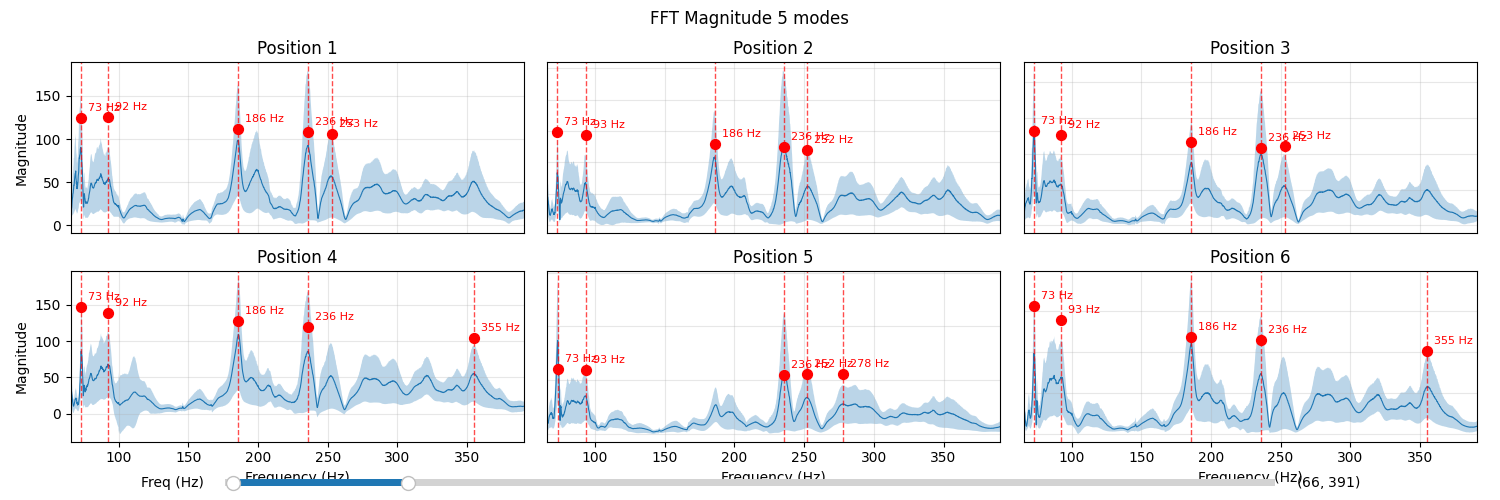

In [ ]:
fig = plot_fft_with_modes(data)

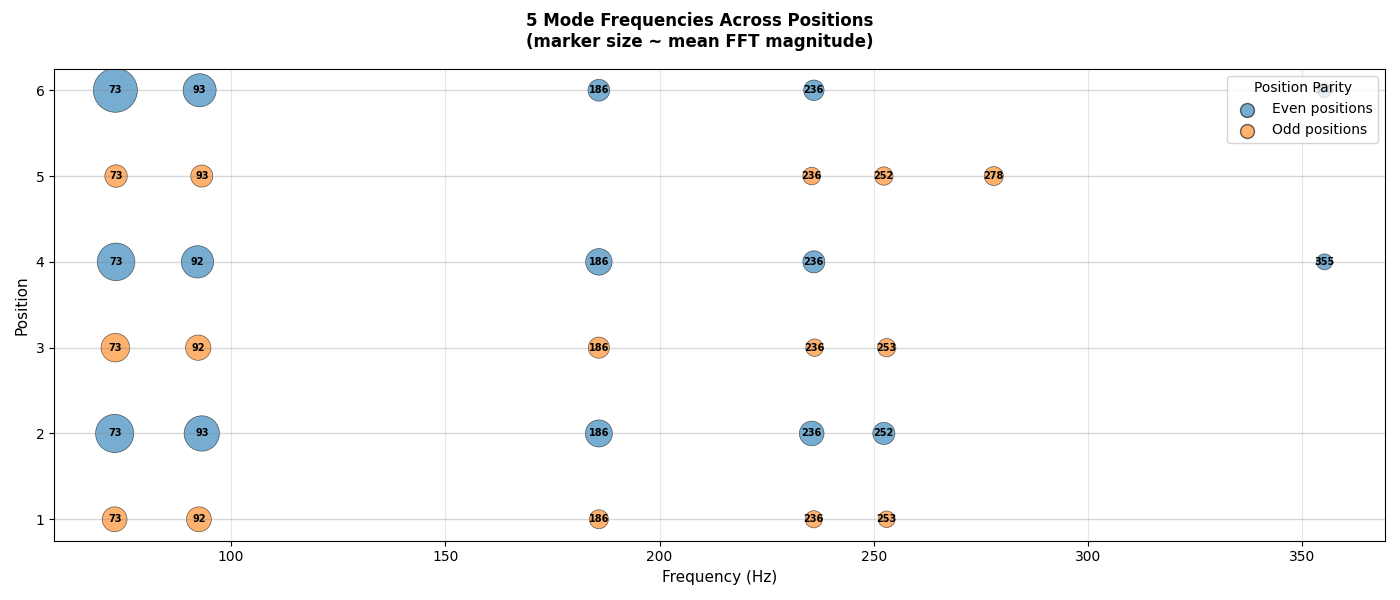

In [ ]:
fig = plot_mode_frequency_overlap(data)
plt.show()

Based on our graphs, let's define our canonical modes as the modes from position 3. The canonical modes do not have a '_' in their key names.

In [ ]:
list(data['cube-pos3-01'].keys())

['object',
 'position',
 'duplicate_idx',
 'fs',
 'path',
 'shifts_raw',
 'time',
 'shifts',
 'fft_vals',
 'freqs',
 '_mode_freqs_idx',
 '_mode_freqs',
 '_mode_fft_vals']

In [ ]:
# Use mode frequencies from position 3 as the canonical reference
canonical_mode_freqs = data['cube-pos3-01']['_mode_freqs']

for name, d in data.items():
    # Store the canonical frequencies
    d['mode_freqs'] = canonical_mode_freqs

    # Find the closest frequency index in THIS position's frequency array for each canonical mode frequency
    freq_indices = []
    for target_freq in canonical_mode_freqs:
        idx = np.argmin(np.abs(d['freqs'] - target_freq))
        freq_indices.append(idx)

    d['mode_freqs_idx'] = np.array(freq_indices)

    # Extract FFT values at those indices from THIS position's fft_vals
    d['mode_fft_vals'] = d['fft_vals'][:, freq_indices, :]

# 5. Sync Phases

In [ ]:
def sync_phases(fft_vals, laser_idx=0, xy_idx=0, eps=1e-12):
    fft_vals_synced = fft_vals.copy()             # copy
    ref = fft_vals[laser_idx, :, xy_idx]          # shape (freq,)
    phase = np.conj(ref) / (np.abs(ref)**2 + eps) # unit complex + divide by magnitude
    fft_vals_synced *= phase[None, :, None]       # broadcast over lasers and xy
    assert np.allclose(1, np.real(fft_vals_synced[laser_idx, :, xy_idx])) # check we have magnitude 1
    return fft_vals_synced # (n_lasers, n_freqs, 2)

In [ ]:
def get_gradients(fft_vals, n_lasers):
    """Extract real-valued gradients from complex FFT values, reshaped to (n_modes, 2, grid, grid).

    Args:
        fft_vals: shape (n_lasers^2, n_modes, 2) - complex FFT values
        n_lasers: grid dimension (e.g., 10 for 10x10 grid)

    Returns:
        gradients: shape (n_modes, 2, n_lasers, n_lasers) - real-valued gradients
                   Access as gradients[mode_idx, 0] for dx, gradients[mode_idx, 1] for dy
    """
    fft_vals = np.real(fft_vals)  # shape: (100, n_modes, 2)
    # Reshape: (100, n_modes, 2) -> (10, 10, n_modes, 2) -> (n_modes, 2, 10, 10)
    gradients = fft_vals.reshape(n_lasers, n_lasers, -1, 2)
    gradients = gradients.transpose(2, 3, 0, 1)  # (n_modes, 2, n_lasers, n_lasers)
    return gradients

In [ ]:
for name, d in data.items():
    d['synced_fft_vals'] = sync_phases(d['fft_vals'])
    d['synced_mode_fft_vals'] = sync_phases(d['mode_fft_vals'])
    n_lasers = int(np.sqrt(d['shifts'].shape[0]))
    d['synced_fft_gradients'] = get_gradients(d['synced_fft_vals'], n_lasers)  # shape: (n_freqs, 2, 10, 10)
    d['synced_mode_fft_gradients'] = get_gradients(d['synced_mode_fft_vals'], n_lasers)  # shape: (n_modes, 2, 10, 10)

In [ ]:
d['synced_mode_fft_vals'].shape

(100, 5, 2)

Visualize the mode shapes as quiver plots. Each subplot shows one mode, and you can toggle different box positions on/off to compare their vibration patterns.

/var/folders/f6/vzqh7ynx4n3ft_sx36yv3gbm0000gn/T/ipykernel_97513/3600879795.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


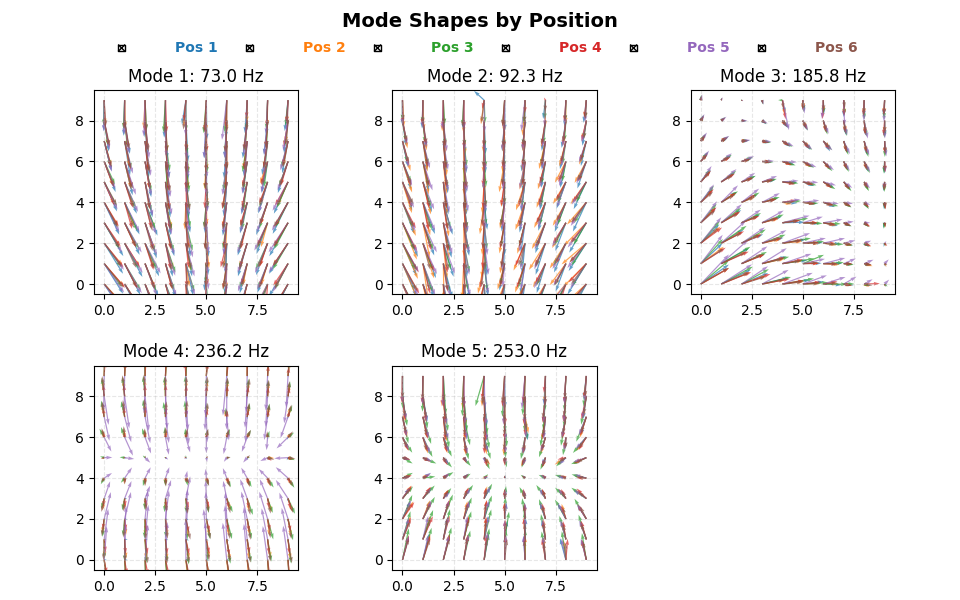

In [ ]:
from matplotlib.widgets import CheckButtons

# Color palette for positions
POSITION_COLORS = {
    1: '#1f77b4',  # blue
    2: '#ff7f0e',  # orange
    3: '#2ca02c',  # green
    4: '#d62728',  # red
    5: '#9467bd',  # purple
    6: '#8c564b',  # brown
}


def plot_mode_quivers(data, n_cols=3, scale_per_mode=False):
    """
    Interactive quiver plot showing mode shapes for all positions.

    Each subplot = one mode. Toggle positions on/off with checkboxes.
    Quiver arrows show (dx, dy) shifts at each laser point for that mode.

    Args:
        data: dict of experiment data
        n_cols: number of columns in subplot grid
        scale_per_mode: if True, each mode is scaled independently for better visibility
    """
    # Get positions (skip duplicates)
    positions = sorted(set(d['position'] for d in data.values() if d['duplicate_idx'] == 1))

    # Get dimensions from first entry
    d0 = next(d for d in data.values() if d['duplicate_idx'] == 1)
    n_modes = len(d0['mode_freqs'])
    n_lasers = int(np.sqrt(d0['shifts'].shape[0]))
    mode_freqs = d0['mode_freqs']

    # Grid coordinates
    X, Y = np.meshgrid(np.arange(n_lasers), np.arange(n_lasers))

    # Setup figure with space for horizontal checkbox bar at top
    n_rows = int(np.ceil(n_modes / n_cols))
    fig = plt.figure(figsize=(3.2*n_cols, 3*n_rows))
    fig.suptitle('Mode Shapes by Position', fontsize=14, fontweight='bold', y=0.98)

    # Leave space at top for title and checkboxes
    gs = fig.add_gridspec(n_rows, n_cols, top=0.85, bottom=0.05, left=0.08, right=0.95, hspace=0.35, wspace=0.25)
    axes = [fig.add_subplot(gs[i // n_cols, i % n_cols]) for i in range(n_modes)]

    # Configure mode axes
    for i, ax in enumerate(axes):
        ax.set_xlim(-0.5, n_lasers - 0.5)
        ax.set_ylim(-0.5, n_lasers - 0.5)
        ax.set_aspect('equal')
        ax.set_title(f'Mode {i+1}: {mode_freqs[i]:.1f} Hz')
        ax.grid(True, alpha=0.3, linestyle='--')

    # State tracking
    active = {pos: True for pos in positions}
    quivers = {}  # (mode_idx, position) -> quiver object

    def compute_scale():
        """Compute quiver scale from active data."""
        if scale_per_mode:
            # Separate scale per mode
            scales = {}
            for mode_idx in range(n_modes):
                max_mag = 0
                for pos in positions:
                    if not active[pos]:
                        continue
                    d = next(d for d in data.values() if d['position'] == pos and d['duplicate_idx'] == 1)
                    dx = d['synced_mode_fft_gradients'][mode_idx, 0]
                    dy = d['synced_mode_fft_gradients'][mode_idx, 1]
                    max_mag = max(max_mag, np.max(np.sqrt(dx**2 + dy**2)))
                scales[mode_idx] = max_mag / 0.2 if max_mag > 0 else 1.0
            return scales
        else:
            # Global scale: max across all modes and positions
            max_mag = 0
            for pos in positions:
                if not active[pos]:
                    continue
                d = next(d for d in data.values() if d['position'] == pos and d['duplicate_idx'] == 1)
                for mode_idx in range(n_modes):
                    dx = d['synced_mode_fft_gradients'][mode_idx, 0]
                    dy = d['synced_mode_fft_gradients'][mode_idx, 1]
                    max_mag = max(max_mag, np.max(np.sqrt(dx**2 + dy**2)))
            return max_mag / 0.2 if max_mag > 0 else 1.0

    def draw():
        """Redraw all quivers."""
        # Clear existing
        for q in quivers.values(): q.remove()
        quivers.clear()

        if not any(active.values()):
            fig.canvas.draw_idle()
            return

        scale = compute_scale()

        # Draw quivers for active positions
        for pos in positions:
            if not active[pos]:
                continue
            d = next(d for d in data.values() if d['position'] == pos and d['duplicate_idx'] == 1)
            color = POSITION_COLORS[pos]

            for mode_idx, ax in enumerate(axes):
                # Gradients shape: (n_modes, 2, n_lasers, n_lasers)
                dx = d['synced_mode_fft_gradients'][mode_idx, 0]
                dy = d['synced_mode_fft_gradients'][mode_idx, 1]

                # Get scale for this mode (dict for per_mode, float otherwise)
                mode_scale = scale[mode_idx] if isinstance(scale, dict) else scale

                q = ax.quiver(X, Y, dx, dy, scale=mode_scale, color=color, alpha=0.7)
                quivers[(mode_idx, pos)] = q

        fig.canvas.draw_idle()

    # Add horizontal checkbox bar at top (below title)
    n_pos = len(positions)
    ax_check = fig.add_axes([0.1, 0.89, 0.8, 0.06])
    ax_check.set_frame_on(False)

    labels = [f'Pos {p}' for p in positions]
    check = CheckButtons(ax_check, labels, [True] * n_pos)

    # Reposition checkboxes horizontally
    horizontal_positions = []
    for i in range(n_pos):
        x_pos = (i + 0.5) / n_pos
        horizontal_positions.append([x_pos - 0.05, 0.5])

    # Move frames and checks
    check._frames.set_offsets(horizontal_positions)
    check._checks.set_offsets(horizontal_positions)

    # Move and color labels
    for i, (label, pos) in enumerate(zip(check.labels, positions)):
        x_pos = (i + 0.5) / n_pos
        label.set_position((x_pos + 0.02, 0.5))
        label.set_color(POSITION_COLORS[pos])
        label.set_fontweight('bold')
        label.set_fontsize(10)

    def on_click(label):
        pos = int(label.split()[-1])
        active[pos] = not active[pos]
        draw()

    check.on_clicked(on_click)

    # Initial draw
    draw()

    # Keep reference to prevent garbage collection
    fig._check = check
    plt.tight_layout()

    return fig


fig = plot_mode_quivers(data, scale_per_mode=True)
plt.show()

# 6. PCA

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
def compute_pca(data, max_n_components, x_key, y_key, fft_mode='both', return_x=False):
    """Compute PCA on FFT data from all experiments.

    Args:
        data: dict of experiment data
        max_n_components: max number of PCA components
        x_key: key for FFT values in data (e.g., 'synced_fft_vals')
        y_key: key for labels in data (e.g., 'position')
        fft_mode: 'both' (magnitude + angle), 'magnitude', or 'angle'

    Returns:
        X_pca: PCA-transformed features, shape (n_samples, n_components)
        y: labels array, shape (n_samples,)
        var_exp: explained variance ratio per component
    """
    assert fft_mode in ['both', 'magnitude', 'angle']

    feature_vectors = []
    labels = []

    for name, d in data.items():
        fft_vals = d[x_key]  # shape: (n_lasers, n_modes, n_coords)
        features = fft_vals.flatten()

        # Convert complex FFT to real features based on mode
        if 'fft' in x_key and 'gradients' not in x_key:
            if fft_mode == 'magnitude':
                features = np.abs(fft_vals).flatten()
            elif fft_mode == 'angle':
                features = np.angle(fft_vals).flatten()
            else:  # 'both'
                mag = np.abs(fft_vals).flatten()
                ang = np.angle(fft_vals).flatten()
                features = np.concatenate([mag, ang])

        feature_vectors.append(features)
        labels.append(d[y_key])

    # Stack into matrix
    X = np.vstack(feature_vectors)
    y = np.array(labels)

    # Normalize using StandardScaler
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # PCA
    n_components = min(max_n_components, X.shape[0])
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    X_pca = pca.fit_transform(X_normalized)

    if return_x: return X_pca, y, pca.explained_variance_ratio_, X
    return X_pca, y, pca.explained_variance_ratio_

In [ ]:
def compute_pairwise_distance(X_pca, y):
    """Compute pairwise Euclidean distance matrix and duplicate position accuracy score.

    Args:
        X_pca: array of shape (n_samples, n_features)
        y: array of position labels, shape (n_samples,)

    Returns:
        distances: pairwise distance matrix of shape (n_samples, n_samples)
        duplicate_score: fraction of duplicate pairs where the closest sample has the same position
    """
    distances = cdist(X_pca, X_pca, metric='euclidean')

    # Find duplicate positions (positions that appear more than once)
    unique_positions, counts = np.unique(y, return_counts=True)
    duplicate_positions = unique_positions[counts > 1]

    if len(duplicate_positions) == 0:
        return distances, None  # No duplicates to compare

    # Create a mask for samples with duplicate positions
    duplicate_mask = np.isin(y, duplicate_positions)
    duplicate_indices = np.where(duplicate_mask)[0]

    # Set diagonal to infinity to exclude self-comparisons
    distances_copy = distances.copy()
    np.fill_diagonal(distances_copy, np.inf)

    # For each duplicate sample, find the closest sample
    closest_indices = np.argmin(distances_copy[duplicate_indices], axis=1)

    # Check if the closest samples have the same position
    y_duplicates = y[duplicate_indices]
    y_closest = y[closest_indices]
    correct_matches = np.sum(y_duplicates == y_closest)

    total_duplicate_pairs = len(duplicate_indices)
    duplicate_score = correct_matches / total_duplicate_pairs if total_duplicate_pairs > 0 else 0.0

    return distances, duplicate_score

In [ ]:
def plot_pca(X_pca, y, var_exp, title="", plot_2d=True, plot_3d=True):
    """Visualize PCA results in 2D and/or 3D with labeled scatter plots.

    Args:
        X_pca: PCA-transformed features, shape (n_samples, n_components)
        y: position labels, shape (n_samples,)
        var_exp: explained variance ratio per component
        plot_2d: if True, create 2D plot (PC1 vs PC2)
        plot_3d: if True, create 3D plot (PC1 vs PC2 vs PC3)

    Returns:
        fig: matplotlib figure object
    """
    # Determine subplot layout
    n_plots = int(plot_2d) + int(plot_3d)
    if n_plots == 0:
        raise ValueError("At least one of plot_2d or plot_3d must be True")

    # Create figure
    fig = plt.figure(figsize=(4.5 * n_plots, 4))
    plot_idx = 1

    # Get unique positions and assign colors
    unique_positions = np.unique(y)
    colors = [POSITION_COLORS.get(pos, f'C{i}') for i, pos in enumerate(unique_positions)]

    # 2D plot
    if plot_2d:
        ax = fig.add_subplot(1, n_plots, plot_idx)

        for pos, color in zip(unique_positions, colors):
            mask = y == pos
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                      c=color, s=200, alpha=0.7,
                      edgecolor='black', linewidth=1.5,
                      label=f'Pos {pos}')

            # Add position labels on top of each point
            for x, y_val in zip(X_pca[mask, 0], X_pca[mask, 1]):
                ax.text(x, y_val, str(pos),
                       ha='center', va='center',
                       fontsize=10, fontweight='bold', color='white')

        ax.set_xlabel(f'PC1 ({var_exp[0]*100:.1f}% variance)', fontsize=11)
        ax.set_ylabel(f'PC2 ({var_exp[1]*100:.1f}% variance)', fontsize=11)
        ax.set_title('PCA Projection (2D)', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)

        plot_idx += 1

    # 3D plot
    if plot_3d:
        from mpl_toolkits.mplot3d import proj3d

        ax = fig.add_subplot(1, n_plots, plot_idx, projection='3d')

        for pos, color in zip(unique_positions, colors):
            mask = y == pos
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
                      c=color, s=200, alpha=0.7,
                      edgecolor='black', linewidth=1.5,
                      label=f'Pos {pos}', depthshade=False)

        # Add all labels after scatter plots to ensure they render on top
        for i in range(len(y)):
            ax.text(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], str(y[i]),
                   ha='center', va='center',
                   fontsize=10, fontweight='bold', color='white',
                   zorder=100)

        ax.set_xlabel(f'PC1 ({var_exp[0]*100:.1f}%)', fontsize=10)
        ax.set_ylabel(f'PC2 ({var_exp[1]*100:.1f}%)', fontsize=10)
        ax.set_zlabel(f'PC3 ({var_exp[2]*100:.1f}%)', fontsize=10)
        ax.set_title('PCA Projection (3D)', fontsize=13, fontweight='bold')

    if title: fig.suptitle(title)
    plt.tight_layout()
    return fig

In [ ]:
def plot_explained_variance(var_exp, title='PCA Explained Variance'):
    """Plot explained variance ratio per component as bar chart with cumulative line.

    Args:
        var_exp: array of explained variance ratios per component
        title: plot title

    Returns:
        fig: matplotlib figure object
    """
    n_components = len(var_exp)
    x = np.arange(1, n_components + 1)
    cumulative = np.cumsum(var_exp)

    fig, ax = plt.subplots(figsize=(8, 5))

    # Bar chart for individual variance
    bars = ax.bar(x, var_exp * 100, color='steelblue', alpha=0.7,
                  edgecolor='black', linewidth=1, label='Individual')

    # Add percentage labels on bars
    for bar, var in zip(bars, var_exp):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1,
                f'{var*100:.1f}%', ha='center', va='bottom', fontsize=9)

    # Line plot for cumulative variance
    ax.plot(x, cumulative * 100, 'o-', color='darkorange', linewidth=2,
            markersize=8, label='Cumulative')

    # Add cumulative percentage labels
    for xi, cum in zip(x, cumulative):
        ax.text(xi + 0.1, cum * 100 + 2, f'{cum*100:.1f}%',
                ha='left', va='bottom', fontsize=9, color='darkorange')

    ax.set_xlabel('Principal Component', fontsize=11)
    ax.set_ylabel('Explained Variance (%)', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'PC{i}' for i in x])
    ax.set_ylim(0, 110)
    ax.legend(loc='center right')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    return fig

In [ ]:
list(d.keys())

['object',
 'position',
 'duplicate_idx',
 'fs',
 'path',
 'shifts_raw',
 'time',
 'shifts',
 'fft_vals',
 'freqs',
 '_mode_freqs_idx',
 '_mode_freqs',
 '_mode_fft_vals',
 'mode_freqs',
 'mode_freqs_idx',
 'mode_fft_vals',
 'synced_fft_vals',
 'synced_mode_fft_vals',
 'synced_fft_gradients',
 'synced_mode_fft_gradients']

In [ ]:
x_key='synced_fft_vals'

X_pca, y, var_exp = compute_pca(
    data, max_n_components=8,
    x_key=x_key, y_key='position', fft_mode='magnitude'
    )
dist_matrix, duplicate_score = compute_pairwise_distance(X_pca, y)

var_exp

array([3.00153395e-01, 1.84195371e-01, 1.25772401e-01, 1.10455861e-01,
       1.09390967e-01, 1.01743374e-01, 6.82886312e-02, 5.80132071e-29])

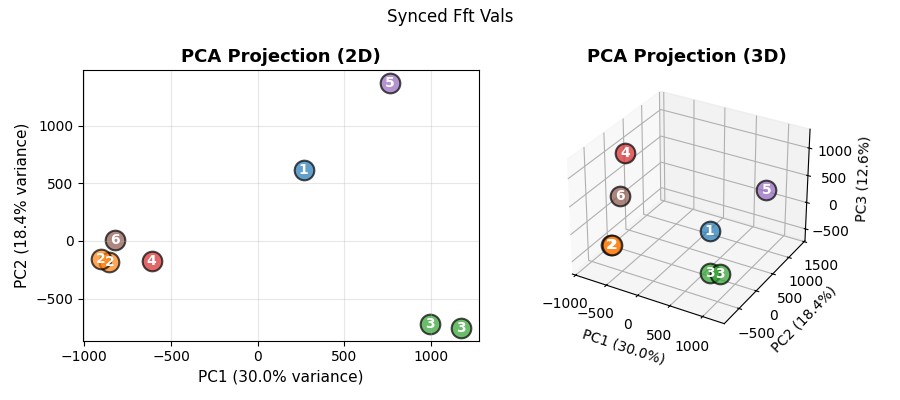

In [ ]:
# Plot both 2D and 3D
fig = plot_pca(X_pca, y, var_exp, title=x_key.replace('_', ' ').title())
plt.show()

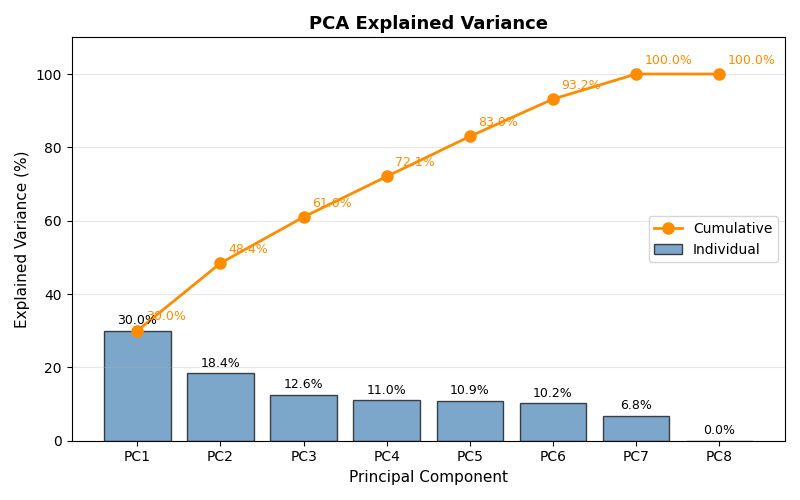

In [ ]:
fig = plot_explained_variance(var_exp)
plt.show()

In [ ]:
list(d.keys())

['object',
 'position',
 'duplicate_idx',
 'fs',
 'path',
 'shifts_raw',
 'time',
 'shifts',
 'fft_vals',
 'freqs',
 '_mode_freqs_idx',
 '_mode_freqs',
 '_mode_fft_vals',
 'mode_freqs',
 'mode_freqs_idx',
 'mode_fft_vals',
 'synced_fft_vals',
 'synced_mode_fft_vals',
 'synced_fft_gradients',
 'synced_mode_fft_gradients']

In [ ]:
x_keys = ['shifts_raw', 'shifts', 'fft_vals', 'synced_fft_vals', 'synced_mode_fft_vals', 'synced_mode_fft_gradients']
labels = ['1. Raw Shifts', '2. Cleaned Shifts', '3. FFT Magnitude', '4. Synced FFT Magnitude', '5. Mode Synced FFT Magnitude', '6. Mode Synced Gradient']

1. Raw Shifts (6000000 dims) (6000000 dims)
2. Cleaned Shifts (6000000 dims) (6000000 dims)
3. FFT Magnitude (2340200 dims) (2340200 dims)
4. Synced FFT Magnitude (2340200 dims) (2340200 dims)
5. Mode Synced FFT Magnitude (1000 dims) (1000 dims)
6. Mode Synced Gradient (1000 dims) (1000 dims)


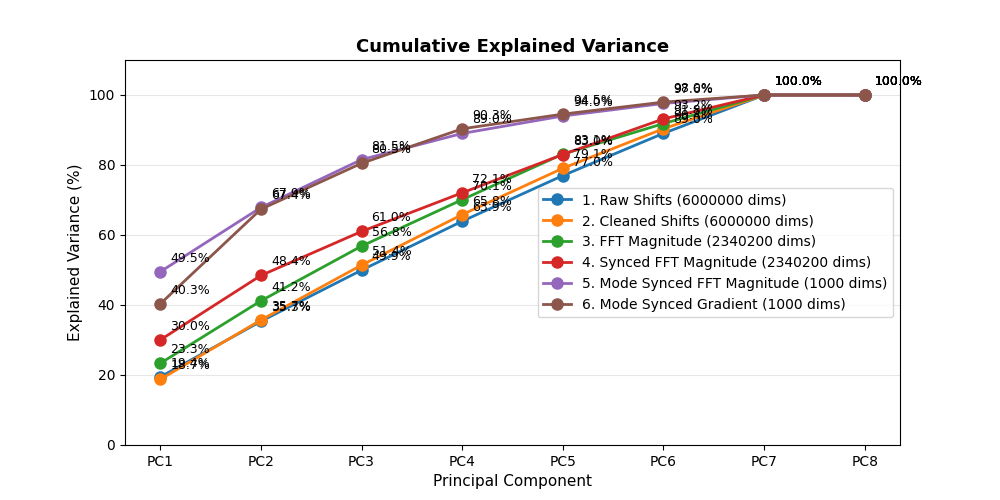

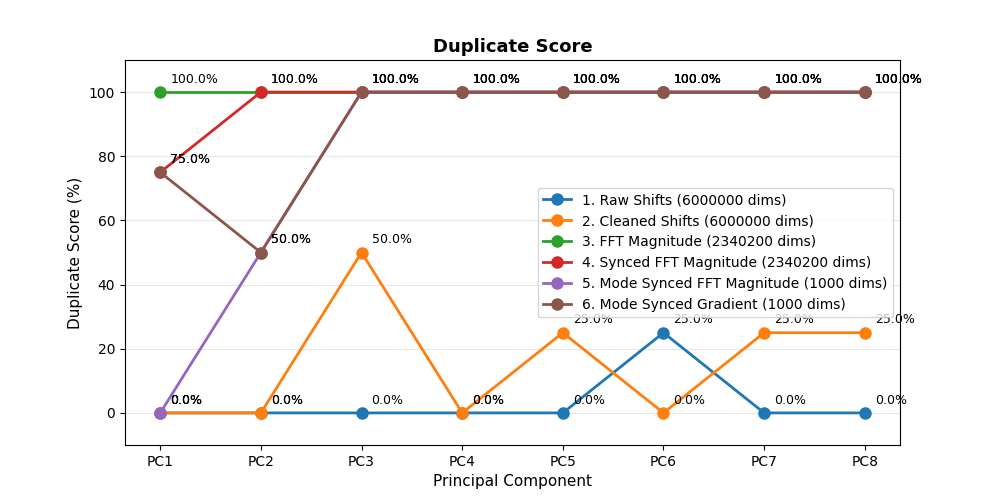

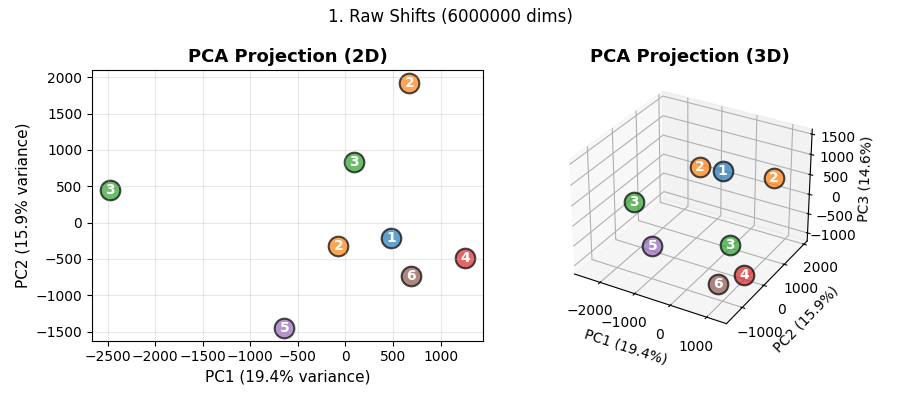

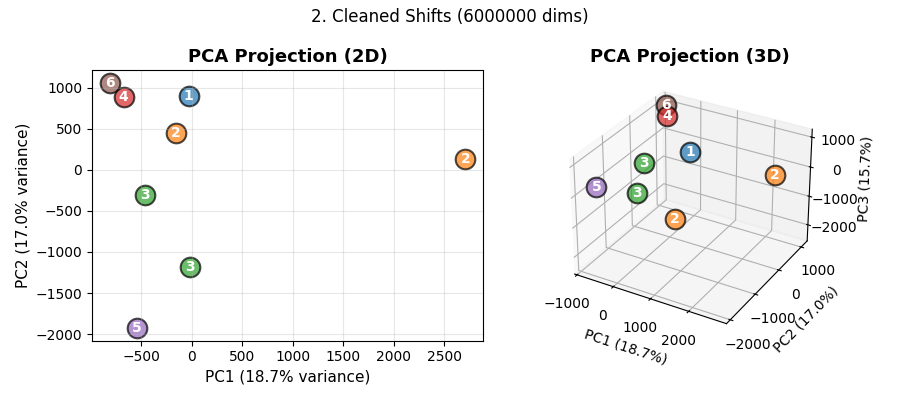

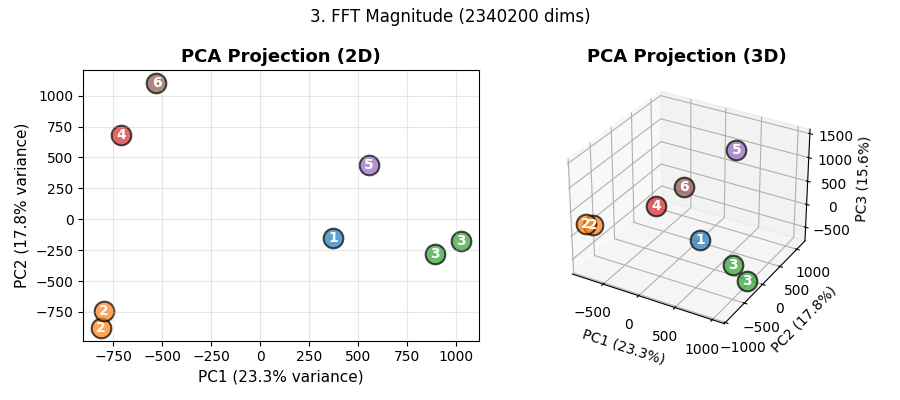

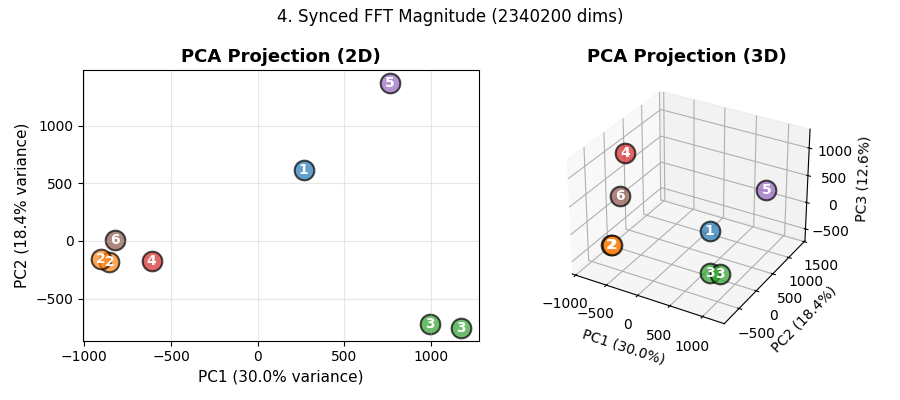

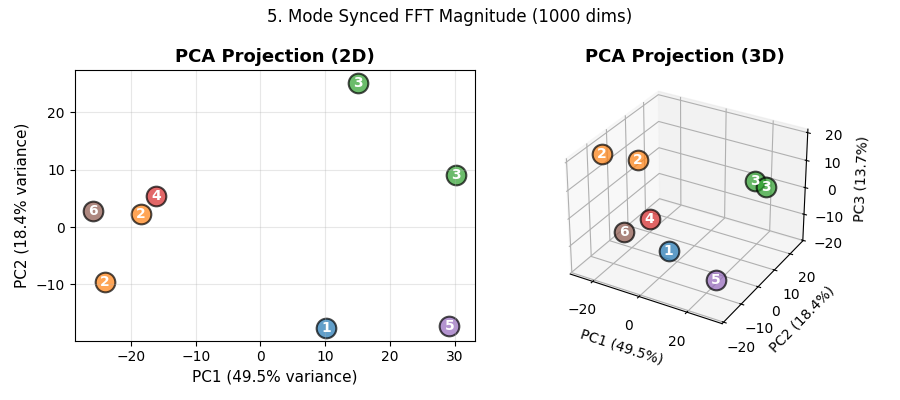

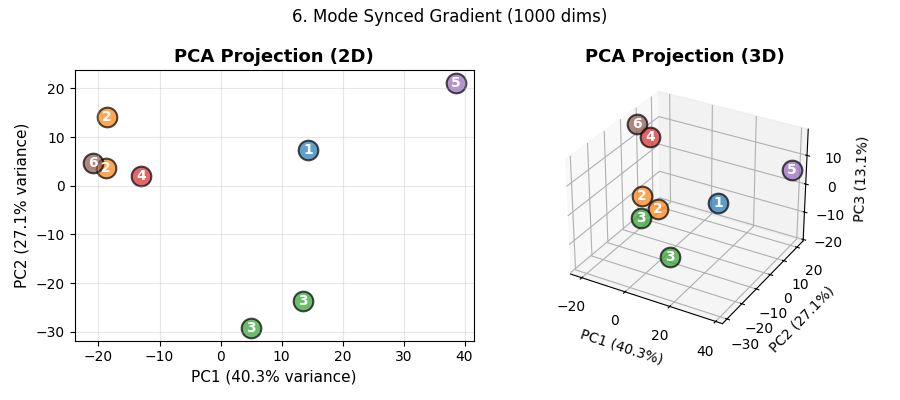

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fi2, ax2 = plt.subplots(figsize=(10, 5))

for x_key, _label in zip(x_keys, labels):
        X_pca, y, var_exp, X = compute_pca(data, max_n_components=8, x_key=x_key, y_key='position', fft_mode='magnitude', return_x=True)

        n_dims = X.shape[1] # todo: shouldn't n_dims be different for mode vs all frequencies?
        label = _label + f' ({n_dims} dims)'
        print(f'{label} ({n_dims} dims)')

        n_components = len(var_exp)
        x = np.arange(1, n_components + 1)
        cumulative = np.cumsum(var_exp)

        # plot cumulative variance
        ax.plot(x, cumulative * 100, 'o-',linewidth=2, markersize=8, label=label)
        for xi, cum in zip(x, cumulative):
                ax.text(xi + 0.1, cum * 100 + 2, f'{cum*100:.1f}%', ha='left', va='bottom', fontsize=9)

        # plot duplicate scores
        duplicate_scores = np.array([compute_pairwise_distance(X_pca[:, :pca_dim+1], y)[1] for pca_dim in range(max_n_components)])
        ax2.plot(x, duplicate_scores*100, 'o-',linewidth=2, markersize=8, label=label)
        for xi, score in zip(x, duplicate_scores):
                ax2.text(xi + 0.1, score * 100 + 2, f'{score*100:.1f}%', ha='left', va='bottom', fontsize=9)

        # plot 2d/3d PCA
        fig3 = plot_pca(X_pca, y, var_exp, title=label)

ax.set_xlabel('Principal Component', fontsize=11)
ax.set_ylabel('Explained Variance (%)', fontsize=11)
ax.set_title('Cumulative Explained Variance', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'PC{i}' for i in x])
ax.set_ylim(0, 110)
ax.legend(loc='center right')
ax.grid(True, alpha=0.3, axis='y')


ax2.set_xlabel('Principal Component', fontsize=11)
ax2.set_ylabel('Duplicate Score (%)', fontsize=11)
ax2.set_title('Duplicate Score', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'PC{i}' for i in x])
ax2.set_ylim(-10, 110)
ax2.legend(loc='center right')
ax2.grid(True, alpha=0.3, axis='y')


In [ ]:
import pandas as pd

In [ ]:
results = []


x_keys = ['shifts_raw', 'shifts', 'fft_vals', 'synced_fft_vals', 'mode_fft_vals', 'synced_mode_fft_vals', 'synced_mode_fft_gradients', 'synced_fft_gradients']

max_n_components = 8
for x_key in x_keys:
    X_pca, y, var_exp, X = compute_pca(data, max_n_components=max_n_components, x_key=x_key, y_key='position', fft_mode='magnitude', return_x=True)

    n_components = len(var_exp)
    x = np.arange(1, n_components + 1)
    cumulative_var_exp = np.cumsum(var_exp)

    n_dims = X.shape[1]
    synced = 'synced' in x_key
    n_modes = (d[x_key].shape[0] if 'gradients' in x_key else d[x_key].shape[1]) if 'mode' in x_key else -1
    signal = x_key.replace('synced_', '').replace('mode_', '').replace('fft_gradients', 'gradients')

    for pca_dim in range(max_n_components):
        _, duplicate_score = compute_pairwise_distance(X_pca[:, :pca_dim+1], y)
        results.append({
            'signal': signal,
            'pca_dim': pca_dim,
            'n_modes': n_modes,
            'synced': synced,
            'n_dims': n_dims,
            'cum_var_exp': cumulative_var_exp[pca_dim],
            'duplicate_score': duplicate_score,
        })

In [ ]:
df = pd.DataFrame(results)
df.head(50)

,signal,pca_dim,n_modes,synced,n_dims,cum_var_exp,duplicate_score
0,shifts_raw,0,-1,False,6000000,0.194276,0.00
1,shifts_raw,1,-1,False,6000000,0.353425,0.00
2,shifts_raw,2,-1,False,6000000,0.499477,0.00
3,shifts_raw,3,-1,False,6000000,0.639295,0.00
4,shifts_raw,4,-1,False,6000000,0.769780,0.00
5,shifts_raw,5,-1,False,6000000,0.890420,0.25
6,shifts_raw,6,-1,False,6000000,1.000000,0.00
7,shifts_raw,7,-1,False,6000000,1.000000,0.00
8,shifts,0,-1,False,6000000,0.187303,0.00
9,shifts,1,-1,False,6000000,0.357147,0.00
